# 10_Model: Xtreme Gradient Boost with only extracted features:

- Complexity
- Lexical / stylometric features

In [14]:
import pandas as pd

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
pd.options.display.max_columns = None
df.head()

,text,headline,n_sents,n_words,avg_words_sents,word_size,unique_words,ttr,mltd,n_words_h,word_size_h,unique_words_h,ttr_h,mltd_h,n_quotes,quotes_ratio,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,8,252,31.500000,4.190476,34.920635,50.000000,58.600559,12,5.583333,100.000000,100.000000,0.00,0,0.000000,15.079365,15.079365,13.888889,11.507937,9.523810,5.555556,6.349206,3.174603,0.000000,1
1,un paso más cerca de hacer los exámenes 'onlin...,un paso más cerca de hacer los exámenes 'online',9,486,54.000000,4.255144,32.716049,44.238683,41.283136,11,3.636364,81.818182,90.909091,33.88,4,0.823045,16.666667,15.226337,12.345679,11.111111,18.930041,1.234568,3.292181,1.646091,1.851852,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,31,980,31.612903,4.815306,26.020408,38.571429,80.551467,12,4.833333,83.333333,91.666667,40.32,39,3.979592,4.795918,17.857143,13.979592,12.755102,11.836735,2.551020,10.306122,4.693878,0.510204,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,11,369,33.545455,4.728997,22.764228,37.398374,50.995314,7,6.857143,100.000000,100.000000,0.00,4,1.084011,4.065041,22.493225,18.157182,15.176152,11.111111,2.710027,7.317073,0.271003,1.355014,1
4,a *number* día del mundial\nfifa.com sigue la ...,a *number* día del mundial,5,130,26.000000,4.461538,48.461538,60.000000,47.081602,7,3.142857,71.428571,85.714286,13.72,0,0.000000,14.615385,14.615385,17.692308,13.846154,9.230769,3.076923,4.615385,1.538462,2.307692,1


In [3]:
df.shape

(971, 26)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 26 columns):
text               971 non-null object
headline           971 non-null object
n_sents            971 non-null int64
n_words            971 non-null int64
avg_words_sents    971 non-null float64
word_size          971 non-null float64
unique_words       971 non-null float64
ttr                971 non-null float64
mltd               971 non-null float64
n_words_h          971 non-null int64
word_size_h        971 non-null float64
unique_words_h     971 non-null float64
ttr_h              971 non-null float64
mltd_h             971 non-null float64
n_quotes           971 non-null int64
quotes_ratio       971 non-null float64
propn_ratio        971 non-null float64
noun_ratio         971 non-null float64
adp_ratio          971 non-null float64
det_ratio          971 non-null float64
punct_ratio        971 non-null float64
pron_ratio         971 non-null float64
verb_ratio         971 no

In [5]:
df.columns

Index(['text', 'headline', 'n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

## Grid search

In [59]:
%%time

import pandas as pd
import numpy as np

from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

########### Combine features & train, test split ########### 

numerical_features = ['n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numerical_features].values
feature_names = df[numerical_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB GRID SEARCH ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.01, 0.02, 0.03],
              'n_estimators': [200, 400, 800, 1000, 1200],
              'max_depth': [2, 4, 6, 8], 
              'subsample': [0.2, 0.3, 0.4], 
              'colsample_bytree': [0.2, 0.5],
              'min_child_weight' : [0.5, 1, 2, 3],
              'lambda': [0.5, 1, 1.5],
              'alpha': [0, 0.2, 0.4]}

folds = 3
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 43)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, 
                                   scoring = 'roc_auc', n_jobs = 4, cv = skf.split(X_train, y_train), verbose = 3)

grid_search.fit(X_train, y_train)

########### Grid search results ###########
print('\n Best estimator:')
print(grid_search.best_estimator_)
best_estimator = grid_search.best_estimator_

print('\n Best score:')
print(grid_search.best_score_ * 2 - 1)

print('\n Best parameters:')
print(grid_search.best_params_)

Fitting 3 folds for each of 12960 candidates, totalling 38880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 1000 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 2280 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 3112 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 4072 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 5160 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 7308 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 8044 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 8844 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 9708 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done 10636 tasks      | elapsed: 11.5m


 Best estimator:
XGBClassifier(alpha=0.4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=0.5, learning_rate=0.03,
              max_delta_step=0, max_depth=4, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0.400000006,
              reg_lambda=0.5, scale_pos_weight=0.9775967413441956, seed=43,
              subsample=0.3, tree_method='exact', validate_parameters=1, ...)

 Best score:
0.7903839455563595

 Best parameters:
{'alpha': 0.4, 'colsample_bytree': 0.2, 'lambda': 0.5, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.3}
CPU times: user 2min 3s, sys: 10.2 s, total: 2min 13s
Wall time: 45min 38s


## Full model

Testing AUC: 0.850798


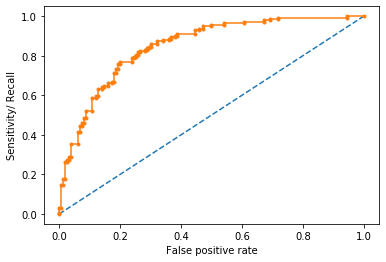

Logloss: 7.81
Accuracy: 77.40


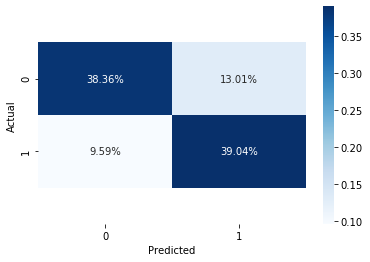

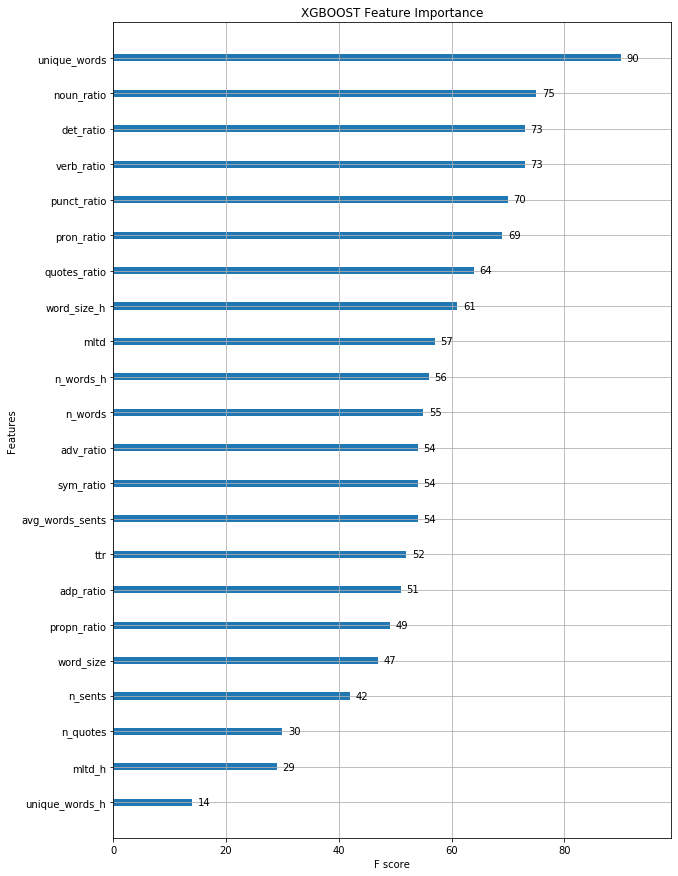

In [60]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v4.csv')
y = df['label']

########### Training and testing split ########### 

numerical_features = ['n_sents', 'n_words', 'avg_words_sents',
       'word_size', 'unique_words', 'ttr', 'mltd', 'n_words_h', 'word_size_h',
       'unique_words_h', 'mltd_h', 'n_quotes', 'quotes_ratio',
       'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio',
       'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

X = df[numerical_features]
tfvocab = df[numerical_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'alpha': 0.4, 
              'colsample_bytree': 0.2, 
              'lambda': 0.5, 
              'learning_rate': 0.03, 
              'max_depth': 4, 
              'min_child_weight': 3, 
              'n_estimators': 200, 
              'subsample': 0.3}

xgb_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve

plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (xgb_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();


########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 15])
axsub = xgb.plot_importance(xgb_model, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]

# feature importance
plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(list_yticklabels)
plt.show()

## Save the model

In [64]:
import pickle
pickle.dump(xgb_model , open('../predictors/fake_news_predictorv2.pkl', 'wb'))

In [65]:
model = pickle.load(open('../predictors/fake_news_predictorv2.pkl', 'rb'))
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.9775967413441956, seed=43, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)